In [32]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import glob as gb
import os
import matplotlib.dates as mdates

%matplotlib inline

In [141]:
# Load HDF file

# measurementID = 1468839251.314217  # 2 min run
measurementID = 1468842626.585271  # 4 min run
    
df = pd.HDFStore('Data/ConcentrationSweep/' + str(measurementID) + '/analysis.h5')['df']

# Create column for time since start of measurement
df['delta'] = (df['datetime']-df['datetime'][0]).fillna(0).astype('timedelta64[us]')/(1E6*60)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13054 entries, 0 to 13053
Data columns (total 19 columns):
datetime            13054 non-null datetime64[ns]
chip                13054 non-null object
concentration       13054 non-null float64
current             13054 non-null float64
fs                  13054 non-null float64
humidity            13054 non-null object
measurementID       13054 non-null float64
medium              13054 non-null object
power               13054 non-null float64
run_time            13054 non-null int64
sample_no           13054 non-null int64
sweep_no            13054 non-null int64
tempC               13054 non-null object
thermocouple_in     13054 non-null object
thermocouple_out    13054 non-null object
A                   13054 non-null float64
tau                 13054 non-null float64
c                   13054 non-null float64
delta               13054 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(3), object(6)
memory usage: 2.0+ M

In [142]:
# Get some useful data for plotting later
flush_time = df['run_time'][0]

In [143]:
df.head()
# df.info()

,datetime,chip,concentration,current,fs,humidity,measurementID,medium,power,run_time,sample_no,sweep_no,tempC,thermocouple_in,thermocouple_out,A,tau,c,delta
0,2016-07-18 12:51:42.550616,T6,0.0,0.5,0.0001,46.89,1.468843e+09,Intralipid (%),0.27,4,1000,1,26.75,22.75,22.75,1.794230,7.090252,0.016865,0.000000
1,2016-07-18 12:51:43.355662,T6,0.0,0.5,0.0001,46.89,1.468843e+09,Intralipid (%),0.27,4,1000,2,26.75,22.75,22.75,1.806391,7.073986,0.017356,0.013417
2,2016-07-18 12:51:43.655679,T6,0.0,0.5,0.0001,46.89,1.468843e+09,Intralipid (%),0.27,4,1000,3,26.75,22.75,22.75,1.794741,7.102827,0.016605,0.018418
3,2016-07-18 12:51:43.861691,T6,0.0,0.5,0.0001,46.89,1.468843e+09,Intralipid (%),0.27,4,1000,4,26.75,22.75,22.75,1.803887,7.075793,0.016844,0.021851
4,2016-07-18 12:51:44.059702,T6,0.0,0.5,0.0001,46.89,1.468843e+09,Intralipid (%),0.27,4,1000,5,26.75,22.75,22.75,1.781776,7.121011,0.015683,0.025151


# Real time

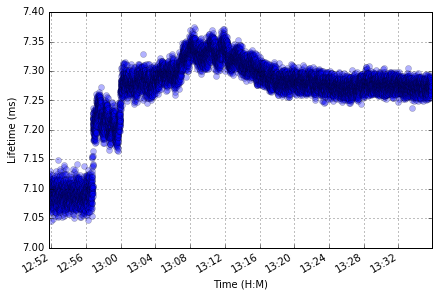

In [144]:
# Create plot of lifetime vs time
fig, ax = plt.subplots()
ax.plot(df['datetime'], df['tau'], 'o', alpha=0.3)
# ax.plot(df['datetime'], df['tempC'], '-')

# format the ticks
# ax.xaxis.set_major_locator(mdates.HourLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=np.arange(0, 60, flush_time)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()  # Rotate slightly

ax.xaxis.grid(True, which="major")
ax.yaxis.grid()
plt.tight_layout()
plt.ticklabel_format(useOffset=False, axis='y')

plt.xlabel('Time (H:M)')
plt.ylabel('Lifetime (ms)')
# plt.savefig("Data/" + str(timestamp) + '/lifetimeVsTime.png', dpi=500)

In [152]:
# Drop first 600 sweeps (300 sweeps = 1 min @ 5HZ capture rate)
df = df[df.sweep_no > 600]
# df = df[df.sweep_no < 900]

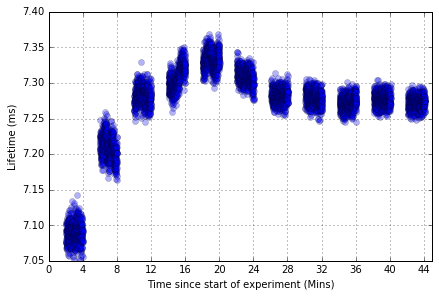

In [153]:
# Create plot of lifetime vs time
fig, ax = plt.subplots()
ax.plot(df['delta'], df['tau'], 'o', alpha=0.3)

ax.xaxis.grid(True, which="major")
ax.yaxis.grid()
plt.xticks(np.arange(0, max(df['delta'])+1, flush_time))
plt.tight_layout()
plt.ticklabel_format(useOffset=False, axis='y')

plt.xlabel('Time since start of experiment (Mins)')
plt.ylabel('Lifetime (ms)')
# plt.savefig("Data/" + str(timestamp) + '/lifetimeVsTime.png', dpi=500)

# Rolling Mean

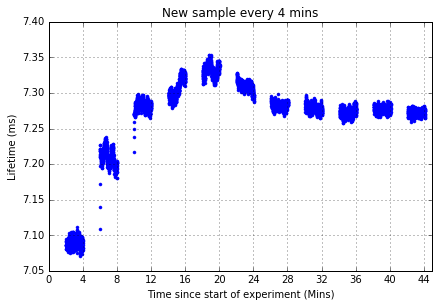

In [154]:
r = df.set_index('delta').rolling(window=5)

fig, ax = plt.subplots()
ax.plot(r['tau'].mean(), '.')

ax.xaxis.grid(True, which="major")
ax.yaxis.grid()
plt.xticks(np.arange(0, max(df['delta'])+1, flush_time))
plt.tight_layout()
plt.ticklabel_format(useOffset=False, axis='y')

plt.title('New sample every {:d} mins'.format(flush_time))
plt.xlabel('Time since start of experiment (Mins)')
plt.ylabel('Lifetime (ms)')
# plt.savefig("Data/" + str(timestamp) + '/lifetimeVsTime.png', dpi=500)

# Each concentration vs lifetime

/Users/Thomas/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


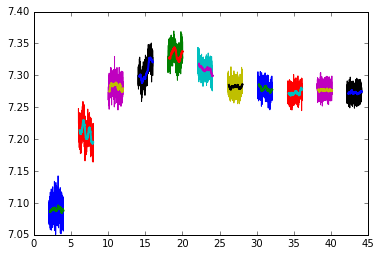

In [159]:
# All in one
for key, grp in df.groupby(['concentration']):
    plt.plot(grp['delta'], grp['tau'], label=key)
    grp['rolling'] = grp['tau'].rolling(window=50).mean()
    plt.plot(grp['delta'], grp['rolling'], lw=2, label='rolling ({k})'.format(k=key))  
# plt.legend(loc='best', ncol=3) 

/Users/Thomas/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


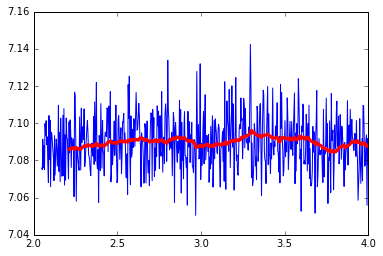

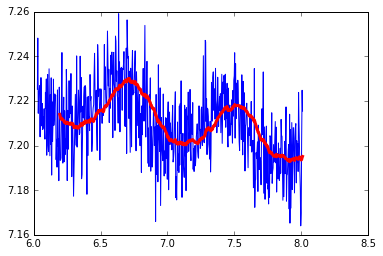

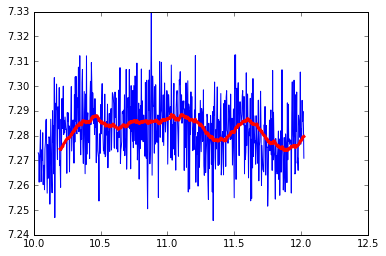

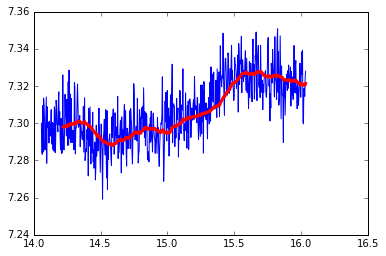

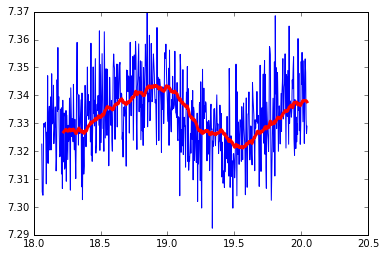

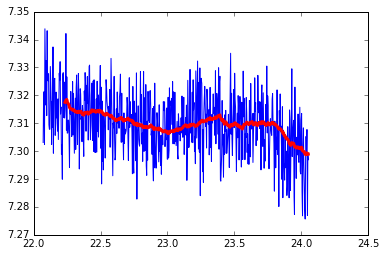

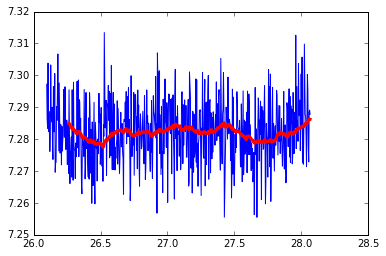

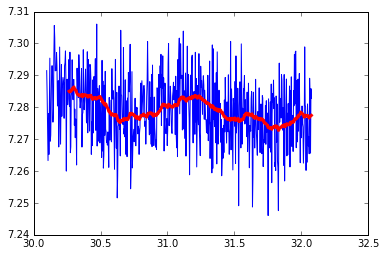

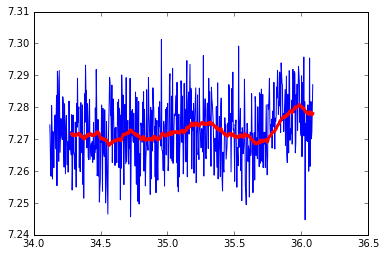

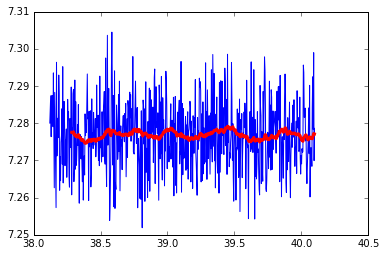

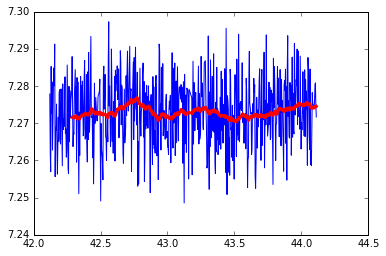

In [156]:
# Individual plots
for key, grp in df.groupby(['concentration']):
    plt.figure()
    plt.plot(grp['delta'], grp['tau'], label=key)
    grp['rolling'] = grp['tau'].rolling(window=50).mean()
    plt.plot(grp['delta'], grp['rolling'], lw=3, color='red', label='rolling ({k})'.format(k=key))  

## tau & A vs concentration

In [164]:
grouped = df.groupby(['concentration'])
mean = grouped.mean()
stdd = grouped.std()

mean.head()

,current,fs,measurementID,power,run_time,sample_no,sweep_no,A,tau,c,delta
concentration,,,,,,,,,,,
0.0,0.5,0.0001,1.468843e+09,0.27,4.0,1000.0,892.0,1.788727,7.089558,0.016458,3.022833
2.0,0.5,0.0001,1.468843e+09,0.27,4.0,1000.0,896.5,2.178787,7.209824,0.017254,7.019711
4.0,0.5,0.0001,1.468843e+09,0.27,4.0,1000.0,894.0,2.595809,7.282202,0.018622,11.024984
6.0,0.5,0.0001,1.468843e+09,0.27,4.0,1000.0,895.0,2.875004,7.307115,0.019557,15.046489
8.0,0.5,0.0001,1.468843e+09,0.27,4.0,1000.0,894.0,2.982664,7.332294,0.020388,19.051385


In [165]:
stdd.head()

,current,fs,measurementID,power,run_time,sample_no,sweep_no,A,tau,c,delta
concentration,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,168.441879,0.008708,0.014452,0.001041,0.564512
2.0,0.0,0.0,0.0,0.0,0.0,0.0,171.039956,0.028663,0.017059,0.001003,0.571393
4.0,0.0,0.0,0.0,0.0,0.0,0.0,169.596580,0.059691,0.012738,0.001047,0.574807
6.0,0.0,0.0,0.0,0.0,0.0,0.0,170.173931,0.035545,0.016944,0.000851,0.572540
8.0,0.0,0.0,0.0,0.0,0.0,0.0,169.596580,0.034807,0.013156,0.001161,0.574761


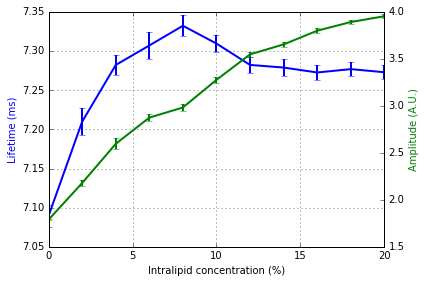

In [166]:
mean = mean.reset_index()
stdd = stdd.reset_index()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.errorbar(mean['concentration'], mean['tau'], yerr=stdd['tau'], color='b', lw='2')
ax2.errorbar(mean['concentration'], mean['A'], yerr=stdd['A'], color='g', lw='2')

ax1.set_xlabel('Intralipid concentration (%)')
ax1.set_ylabel('Lifetime (ms)', color='b')
ax2.set_ylabel('Amplitude (A.U.)', color='g')

ax1.grid()
plt.tight_layout()
ax1.ticklabel_format(useOffset=False, axis='y')
ax2.ticklabel_format(useOffset=False, axis='y')

plt.tight_layout()
# plt.title(df['chip'][0])
# plt.savefig("Data/Plots/together/" + sample + '.png', dpi=500)

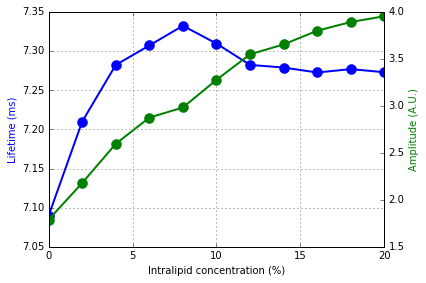

In [103]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(mean['concentration'], mean['tau'], 'b.-', lw='2', markersize=20)
ax2.plot(mean['concentration'], mean['A'], 'g.-', lw='2', markersize=20)

ax1.set_xlabel('Glucose concentration (mmol)')
ax1.set_xlabel('Intralipid concentration (%)')
ax1.set_ylabel('Lifetime (ms)', color='b')
ax2.set_ylabel('Amplitude (A.U.)', color='g')

ax1.grid()
plt.tight_layout()
ax1.ticklabel_format(useOffset=False, axis='y')
ax2.ticklabel_format(useOffset=False, axis='y')

plt.tight_layout()
# plt.title(df['chip'][0])
# plt.savefig("Plots/together/" + sample + '_T12_intralipidConc.png', dpi=500)

## Plot individual sweeps vs concentration

# Old

In [ ]:
grouped = df.groupby(['chip', 'medium', 'concentration'])
grouped = df.groupby(['chip', 'concentration'])
mean = grouped.mean()
std = grouped.std()
mean.head(10)

mean = mean.reset_index()
mean = mean.set_index('chip')
mean.head(10)

mean.index.get_level_values(0).unique()

for sample in mean.index.get_level_values(0).unique():
    data = mean.loc[sample]
    stdd = std.loc[sample]
    
    try:
        
        fig, ax1 = plt.subplots()

        ax2 = ax1.twinx()
        ax1.errorbar(data['concentration'], data['tau'], yerr=stdd['tau'], color='b', lw='2')
        ax2.errorbar(data['concentration'], data['a'], yerr=stdd['a'], color='g', lw='2')

        ax1.set_xlabel('Glucose concentration (mmol)')
        ax1.set_ylabel('Lifetime (ms)', color='b')
        ax2.set_ylabel('Amplitude (A.U.)', color='g')

        ax1.grid()
        plt.tight_layout()
        ax1.ticklabel_format(useOffset=False, axis='y')
        ax2.ticklabel_format(useOffset=False, axis='y')

        plt.title(sample)
#         plt.savefig("Data/Plots/together/" + sample + '.png', dpi=500)
        plt.close()
    except:
        print(sample)
        
for sample in mean.index.get_level_values(0).unique():
    data = mean.loc[sample]
    stdd = std.loc[sample]
    
    try:
        
        fig, ax1 = plt.subplots()

        ax2 = ax1.twinx()
        ax1.plot(data['concentration'], data['tau'], 'b.-', lw='2', markersize=20)
        ax2.plot(data['concentration'], data['a'], 'g.-', lw='2', markersize=20)

        ax1.set_xlabel('Glucose concentration (mmol)')
        ax1.set_xlabel('Intralipid concentration (%)')
        ax1.set_ylabel('Lifetime (ms)', color='b')
        ax2.set_ylabel('Amplitude (A.U.)', color='g')

        ax1.grid()
        plt.tight_layout()
        ax1.ticklabel_format(useOffset=False, axis='y')
        ax2.ticklabel_format(useOffset=False, axis='y')

        plt.title(sample)
        plt.savefig("Plots/together/" + sample + '_T12_intralipidConc.png', dpi=500)
        plt.close()
    except:
        print(sample)